### Task 1
### Fine-tuning VGG16


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

### Load Dataset usign torchvision image loader

In [15]:
data_dir = 'D:/Labs/Deep Learning/Assignment 5 Part 1/Aoun_BSCS17008_05/Assignment 5 Dataset'

In [16]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=15, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=15, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


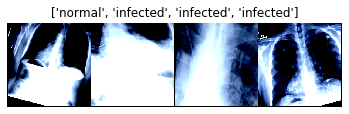

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
valid_inputs, valid_classes = next(iter(validationloader))
show_databatch(inputs, classes)

### Load pre-trained VGG-16

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [ ]:
print(vgg16.classifier[3])

### Modifying FC Layers

In [ ]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[0:4] # Remove last layer
print(features)
features[0].out_features =(8*10)+100 #roll number is bscs17008
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)
print(features)

### Freezing the layers

In [ ]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

### Adding New Layer

In [ ]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

### Loss fucntion and optimizer

In [ ]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('__CUDA VERSION', )
torch.cuda.current_device()
#print('Active CUDA Device: GPU', torch.cuda.current_device())


## Auxiliary Functions

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]



def ValidationExec(validationloader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    v_loss = 0.0
    running_loss = 0.0
    v_total = 0.0
    v_correct = 0.0
    ran = 0.0
    
    validation_labels = []
    validation_prediction = []
    
    with torch.no_grad():
            for v_data in validationloader:
                v_images, v_labels = v_data
                v_images, v_labels = v_images.to(device), v_labels.to(device)
                v_outputs = vgg16(v_images)
                v_loss = criterion(v_outputs, v_labels)
                v_, v_predicted = torch.max(v_outputs.data, 1)
                v_total += labels.size(0)
                v_correct += (v_predicted == v_labels).sum().item()
                running_loss += v_loss.item()
                ran += 1
                validation_labels.extend(v_labels)
                validation_prediction.extend(v_predicted)
                #clearing data
                v_images, v_labels = v_images.to("cpu"), v_labels.to("cpu")
    return v_correct/v_total, running_loss/ran, validation_labels, validation_prediction

### Training

In [9]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train(True)


training_loss = []
acc_training = []
validation_loss = []
acc_validation = []

training_labels = []
training_prediction = []

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    
    v_acc = 0
    v_loss = 0
    
    ran = 0.0
    
    running_loss = 0.0
    total_training = 0.0
    correct_training = 0.0
    
    pbar = tqdm(enumerate(trainloader))
    
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
       
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        
        _, predicted = torch.max(outputs.data, 1) #---> computing accuracy
        
        tot_labels = labels.size(0)
        cor_training = (predicted == labels).sum().item()
        
        total_training += tot_labels
        correct_training += cor_training
        
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        ## building data for confusion Matrix
        if epoch == Epochs-1:
            training_labels.extend(labels)
            training_prediction.extend(predicted)
        
        
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.3f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data, cor_training/tot_labels ))
        ran += 1
    #validation data    
    v_acc, v_loss, validation_labels, validation_prediction = ValidationExec(validationloader)
    print("Validation loss: " + str(v_loss))
    print("Validation acc: " + str(v_acc))
    
    
    training_loss.append(running_loss/ran)
    acc_training.append(correct_training/total_training)
    acc_validation.append(v_acc)
    validation_loss.append(v_loss)
    
    #after epoch statistics:
    print("After epoch training loss: " + str(training_loss[-1]))
    print("After epoch training acc: " + str(acc_training[-1]))
    
    torch.save(vgg16.state_dict(), '‘vgg16_entire.pth')

print('Finished Training')

Train Epoch: 0 [11996/12000 (100%)]	Loss: 0.026121	Acc: 1.000: : 3000it [23:38,  2.12it/s]


Validation loss: 0.3042808924987912
Validation acc: 3.2975
After epoch training loss: 0.5293835815985998
After epoch training acc: 0.7870833333333334


Train Epoch: 1 [11996/12000 (100%)]	Loss: 0.217499	Acc: 0.750: : 3000it [23:16,  2.15it/s]


Validation loss: 0.27457318138331177
Validation acc: 3.345
After epoch training loss: 0.3298266039689382
After epoch training acc: 0.8670833333333333


Train Epoch: 2 [11996/12000 (100%)]	Loss: 0.037241	Acc: 1.000: : 3000it [22:06,  2.26it/s]


Validation loss: 0.3188612776249647
Validation acc: 3.31
After epoch training loss: 0.2916701689561208
After epoch training acc: 0.8896666666666667


Train Epoch: 3 [11996/12000 (100%)]	Loss: 0.211750	Acc: 1.000: : 3000it [21:34,  2.32it/s]


Validation loss: 0.29949565794318916
Validation acc: 3.36
After epoch training loss: 0.27596694278717043
After epoch training acc: 0.8909166666666667


Train Epoch: 4 [11996/12000 (100%)]	Loss: 0.235946	Acc: 1.000: : 3000it [20:57,  2.39it/s]


Validation loss: 0.2601326375082135
Validation acc: 3.3675
After epoch training loss: 0.26198143633206683
After epoch training acc: 0.8979166666666667


Train Epoch: 5 [11996/12000 (100%)]	Loss: 0.095867	Acc: 1.000: : 3000it [19:58,  2.50it/s]


Validation loss: 0.2780472623091191
Validation acc: 3.3725
After epoch training loss: 0.25554603012402854
After epoch training acc: 0.9001666666666667


Train Epoch: 6 [11996/12000 (100%)]	Loss: 0.473227	Acc: 0.500: : 3000it [20:35,  2.43it/s]


Validation loss: 0.244224897432141
Validation acc: 3.3775
After epoch training loss: 0.2447304859161377
After epoch training acc: 0.9068333333333334


Train Epoch: 7 [11996/12000 (100%)]	Loss: 0.108489	Acc: 1.000: : 3000it [20:39,  2.42it/s]


Validation loss: 0.2706687968783081
Validation acc: 3.35
After epoch training loss: 0.23855244660377503
After epoch training acc: 0.9074166666666666


Train Epoch: 8 [11996/12000 (100%)]	Loss: 0.719307	Acc: 0.750: : 3000it [19:58,  2.50it/s]


Validation loss: 0.23093235472217202
Validation acc: 3.4025
After epoch training loss: 0.23335175124804178
After epoch training acc: 0.9109166666666667


Train Epoch: 9 [11996/12000 (100%)]	Loss: 1.153750	Acc: 0.750: : 3000it [20:54,  2.39it/s]


Validation loss: 0.2243208577297628
Validation acc: 3.43
After epoch training loss: 0.22751558486620585
After epoch training acc: 0.9135
Finished Training


## Confusion Matrix and other Stats

In [ ]:
## this is for training

# Scores
pref = perf_measure(training_labels, training_prediction)
print(pref)
#confusion Matrix
tl = []
tp = []
for i in range(0, len(training_labels)):
    tl.append(training_labels[i].item())
    tp.append((training_prediction[i].item()))

plot_confusion_matrix(tl, tp, class_names)
fig = plt.gcf()
fig.show()

In [ ]:
plt.plot(training_loss)

In [ ]:
plt.plot(acc_training)

In [ ]:
plt.plot(acc_validation)

In [ ]:
plt.plot(validation_loss)

In [ ]:
## this is for validatoin

# Scores
pref = perf_measure(validation_labels, validation_prediction)
print(pref)
#confusion Matrix
tl = []
tp = []
for i in range(0, len(validation_labels)):
    tl.append(validation_labels[i].item())
    tp.append((validation_prediction[i].item()))

plot_confusion_matrix(tl, tp, class_names)
fig = plt.gcf()
fig.show()

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


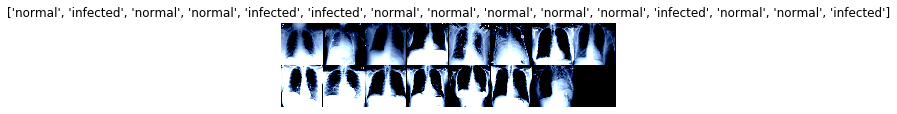

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [27]:
correct = 0
total = 0
predicted = []
labels = []

tot_predicted = []
tot_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        tot_predicted.extend(predicted)
        tot_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


[875, 31, 584, 10]
Confusion matrix, without normalization
[[584  31]
 [ 10 875]]


D:\Softwares\Anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


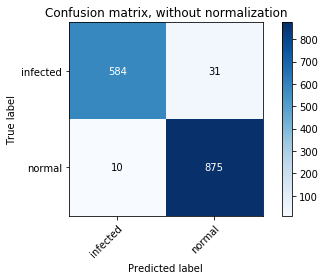

In [28]:
## this is for testing

# Scores
pref = perf_measure(tot_labels, tot_predicted)
print(pref)
#confusion Matrix
tl = []
tp = []
for i in range(0, len(tot_labels)):
    tl.append(tot_labels[i].item())
    tp.append((tot_predicted[i].item()))

plot_confusion_matrix(tl, tp, class_names)
fig = plt.gcf()
fig.show()

In [29]:
recall = (pref[0]*1.0) / (1.0 * pref[0] + pref[3])
precision = (pref[0]*1.0) / (1.0 * pref[0] + pref[1])
f1 = (2 * recall * precision)/ (recall + precision)
print("F1 score is ", f1)

F1 score is  0.9771077610273591


## Task 1 Resnet-18

### Load pre-trained Resnet-18

In [ ]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)


## Modifying Resnet-18

In [ ]:
layers = []
itr = nn.Sequential
layers.append(nn.Linear(resnet18.fc.in_features, 180))
layers.append(nn.Linear(180, len(class_names)))
print(layers)
resnet18.fc= nn.Sequential(*layers)
print(resnet18)

## Freezing Layers


In [ ]:
#freezing all layers
for i in resnet18.children():
    for param in i.parameters():
        param.requires_grad = False



In [ ]:
#fc layer unfreezing
for i in resnet18.fc:
    for param in i.parameters():
        param.requires_grad = True

## Loss Function and Optimizer

In [ ]:
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [68]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]



def ValidationExec(validationloader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    v_loss = 0.0
    running_loss = 0.0
    v_total = 0.0
    v_correct = 0.0
    ran = 0.0
    
    validation_labels = []
    validation_prediction = []
    
    with torch.no_grad():
            for v_data in validationloader:
                v_images, v_labels = v_data
                v_images, v_labels = v_images.to(device), v_labels.to(device)
                v_outputs = resnet18(v_images)
                v_loss = criterion(v_outputs, v_labels)
                v_, v_predicted = torch.max(v_outputs.data, 1)
                v_total += labels.size(0)
                v_correct += (v_predicted == v_labels).sum().item()
                running_loss += v_loss.item()
                ran += 1
                validation_labels.extend(v_labels)
                validation_prediction.extend(v_predicted)
                #clearing data
                v_images, v_labels = v_images.to("cpu"), v_labels.to("cpu")
    return v_correct/v_total, running_loss/ran, validation_labels, validation_prediction

## Training

In [69]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.train(True)


training_loss = []
acc_training = []
validation_loss = []
acc_validation = []

training_labels = []
training_prediction = []

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    
    v_acc = 0
    v_loss = 0
    
    ran = 0.0
    
    running_loss = 0.0
    total_training = 0.0
    correct_training = 0.0
    
    pbar = tqdm(enumerate(trainloader))
    
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
       
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        
        _, predicted = torch.max(outputs.data, 1) #---> computing accuracy
        
        tot_labels = labels.size(0)
        cor_training = (predicted == labels).sum().item()
        
        total_training += tot_labels
        correct_training += cor_training
        
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        ## building data for confusion Matrix
        if epoch == Epochs-1:
            training_labels.extend(labels)
            training_prediction.extend(predicted)
        
        
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.3f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data, cor_training/tot_labels ))
        ran += 1
    #validation data    
    v_acc, v_loss, validation_labels, validation_prediction = ValidationExec(validationloader)
    print("Validation loss: " + str(v_loss))
    print("Validation acc: " + str(v_acc))
    
    
    training_loss.append(running_loss/ran)
    acc_training.append(correct_training/total_training)
    acc_validation.append(v_acc)
    validation_loss.append(v_loss)
    
    #after epoch statistics:
    print("After epoch training loss: " + str(training_loss[-1]))
    print("After epoch training acc: " + str(acc_training[-1]))
    
    #torch.save(resnet18.state_dict(), '‘res18_entire.pth')

print('Finished Training')

Train Epoch: 0 [11996/12000 (100%)]	Loss: 0.538271	Acc: 0.750: : 3000it [12:23,  4.04it/s]
0it [00:00, ?it/s]

Validation loss: 0.6578434836864472
Validation acc: 2.3225
After epoch training loss: 0.6778464131553967
After epoch training acc: 0.5634166666666667


Train Epoch: 1 [11996/12000 (100%)]	Loss: 0.720935	Acc: 0.500: : 3000it [12:06,  4.13it/s]
0it [00:00, ?it/s]

Validation loss: 0.6581751376390457
Validation acc: 2.36
After epoch training loss: 0.6777700139085452
After epoch training acc: 0.5696666666666667


Train Epoch: 2 [11996/12000 (100%)]	Loss: 0.610351	Acc: 0.750: : 3000it [12:12,  4.09it/s]
0it [00:00, ?it/s]

Validation loss: 0.6607290518283844
Validation acc: 2.34
After epoch training loss: 0.6745454147259394
After epoch training acc: 0.58025


Train Epoch: 3 [11996/12000 (100%)]	Loss: 0.780503	Acc: 0.250: : 3000it [12:10,  4.10it/s]
0it [00:00, ?it/s]

Validation loss: 0.6610016268491745
Validation acc: 2.34
After epoch training loss: 0.6763040910065174
After epoch training acc: 0.5709166666666666


Train Epoch: 4 [11996/12000 (100%)]	Loss: 0.722560	Acc: 0.500: : 3000it [11:54,  4.20it/s]
0it [00:00, ?it/s]

Validation loss: 0.6619644808769226
Validation acc: 2.32
After epoch training loss: 0.6761142703096071
After epoch training acc: 0.575


Train Epoch: 5 [11996/12000 (100%)]	Loss: 0.631032	Acc: 0.500: : 3000it [11:25,  4.38it/s]
0it [00:00, ?it/s]

Validation loss: 0.6602333354949951
Validation acc: 2.3175
After epoch training loss: 0.6744373674889406
After epoch training acc: 0.583


Train Epoch: 6 [11996/12000 (100%)]	Loss: 0.805353	Acc: 0.000: : 3000it [12:24,  4.03it/s]
0it [00:00, ?it/s]

Validation loss: 0.6601752650737762
Validation acc: 2.29
After epoch training loss: 0.676632082660993
After epoch training acc: 0.5666666666666667


Train Epoch: 7 [11996/12000 (100%)]	Loss: 0.785598	Acc: 0.250: : 3000it [11:45,  4.25it/s]
0it [00:00, ?it/s]

Validation loss: 0.6579348623752594
Validation acc: 2.365
After epoch training loss: 0.6761852126717568
After epoch training acc: 0.5753333333333334


Train Epoch: 8 [11996/12000 (100%)]	Loss: 0.699906	Acc: 0.500: : 3000it [10:49,  4.62it/s]
0it [00:00, ?it/s]

Validation loss: 0.6604297870397567
Validation acc: 2.3
After epoch training loss: 0.6780048214793205
After epoch training acc: 0.5671666666666667


Train Epoch: 9 [11996/12000 (100%)]	Loss: 0.812022	Acc: 0.000: : 3000it [10:59,  4.55it/s]


Validation loss: 0.660359588265419
Validation acc: 2.3125
After epoch training loss: 0.6756132035354773
After epoch training acc: 0.572
Finished Training


## Confusion Matrix and other Stats

[393, 420, 4499, 6688]
Confusion matrix, without normalization
[[4499  420]
 [6688  393]]


D:\Softwares\Anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


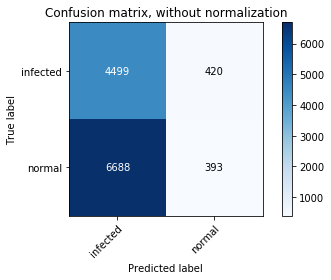

In [20]:
## this is for training

# Scores
pref = perf_measure(training_labels, training_prediction)
print(pref)
#confusion Matrix
tl = []
tp = []
for i in range(0, len(training_labels)):
    tl.append(training_labels[i].item())
    tp.append((training_prediction[i].item()))

plot_confusion_matrix(tl, tp, class_names)
fig = plt.gcf()
fig.show()

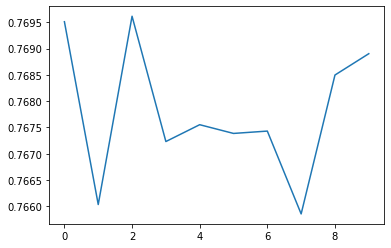

In [21]:
plt.plot(training_loss)

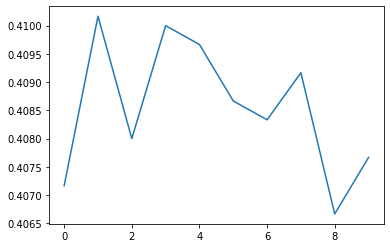

In [22]:
plt.plot(acc_training)

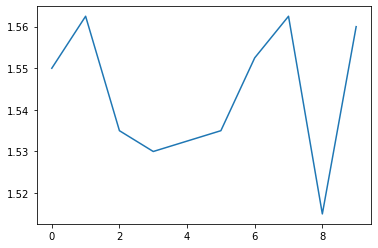

In [23]:
plt.plot(acc_validation)

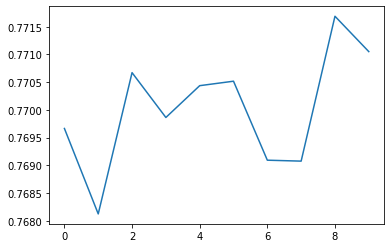

In [24]:
plt.plot(validation_loss)

[67, 58, 557, 818]
Confusion matrix, without normalization
[[557  58]
 [818  67]]


D:\Softwares\Anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


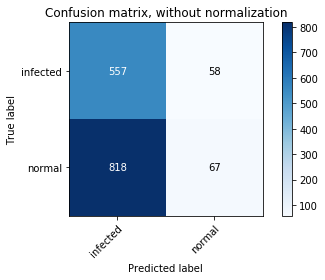

In [25]:
## this is for validatoin

# Scores
pref = perf_measure(validation_labels, validation_prediction)
print(pref)
#confusion Matrix
tl = []
tp = []
for i in range(0, len(validation_labels)):
    tl.append(validation_labels[i].item())
    tp.append((validation_prediction[i].item()))

plot_confusion_matrix(tl, tp, class_names)
fig = plt.gcf()
fig.show()

## Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


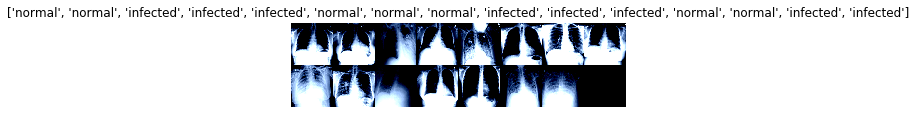

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [71]:
correct = 0
total = 0
predicted = []
labels = []

tot_predicted = []
tot_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        tot_predicted.extend(predicted)
        tot_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


[66, 70, 545, 819]
Confusion matrix, without normalization
[[545  70]
 [819  66]]


D:\Softwares\Anaconda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


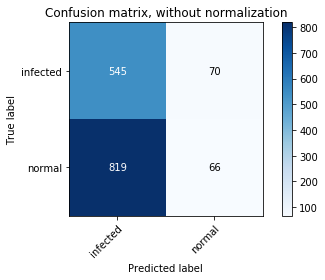

In [32]:
## this is for testing

# Scores
pref = perf_measure(tot_labels, tot_predicted)
print(pref)
#confusion Matrix
tl = []
tp = []
for i in range(0, len(tot_labels)):
    tl.append(tot_labels[i].item())
    tp.append((tot_predicted[i].item()))

plot_confusion_matrix(tl, tp, class_names)
fig = plt.gcf()
fig.show()

In [33]:
recall = (pref[0]*1.0) / (1.0 * pref[0] + pref[3])
precision = (pref[0]*1.0) / (1.0 * pref[0] + pref[1])
f1 = (2 * recall * precision)/ (recall + precision)
print("F1 score is ", f1)

F1 score is  0.12928501469147896


## Task 2 Vgg16

## Loading VGG16

In [5]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)


## Modify VGG16

In [6]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[0:4] # Remove last layer
#print(features)
features[0].out_features =(8*10)+100 #roll number is bscs17008
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)
#print(features)


# Freeze training for all layers
#for param in vgg16.features.parameters():
#    param.requires_grad = False
    
#Now unfreezing first convolution layer
#vgg16.features[0].weight.requires_grad = True
#vgg16.features[0].bias.requires_grad = True

#Now unfreezing first 4 convolution layers
#vgg16.features[0].weight.requires_grad = True
#vgg16.features[0].bias.requires_grad = True
#vgg16.features[2].weight.requires_grad = True
#vgg16.features[2].bias.requires_grad = True
#vgg16.features[5].weight.requires_grad = True
#vgg16.features[5].bias.requires_grad = True
#vgg16.features[7].weight.requires_grad = True
#vgg16.features[7].bias.requires_grad = True


## adding layer
vgg16.classifier = nn.Sequential(*features)

## Setting Hyperparameters

In [7]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

## Task 2 Resnet18

## Loading Resnet18

In [65]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)


## Modifying Resnet18

In [66]:
layers = []
itr = nn.Sequential
layers.append(nn.Linear(resnet18.fc.in_features, 180))
layers.append(nn.Linear(180, len(class_names)))
resnet18.fc= nn.Sequential(*layers)

#freezing all layers
for i in resnet18.children():
    for param in i.parameters():
        param.requires_grad = False
#print(resnet18)

#fc layer unfreezing
for i in resnet18.fc:
    for param in i.parameters():
        param.requires_grad = True
        
#unfreezing 5 convolution layer
resnet18.conv1.weight.requires_grad = True
resnet18.layer1[0].conv1.weight.requires_grad = True
resnet18.layer1[0].conv2.weight.requires_grad = True
resnet18.layer1[1].conv1.weight.requires_grad = True
resnet18.layer1[1].conv2.weight.requires_grad = True

## Setting Hyperparameters

In [67]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)